## Goal
Pricing optimization is, non surprisingly, another area where data science can provide huge value.

The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

## Challenge Description
Company XYZ sells a software for (39). Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ( 39), while a random sample of 33% users a higher price ( 59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

Should the company sell its software for  39 or  59?
The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?
The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.
## Data
We have two tables downloadable by clicking here. The two tables are:

# "test_results" - data about the test
Columns:

+ user_id : the Id of the user. Can be joined to user_id in user_table
+ timestamp : the date and time when the user hit for the first time company XYZ
+ webpage. It is in user local time
+ source : marketing channel that led to the user coming to the site. It can be:
ads-["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from
google ads, yahoo ads, etc.
seo - ["google", "facebook", "bing", "yahoo", "other"]. That is, user coming from google search, yahoo, facebook, etc.
friend_referral : user coming from a referral link of another user
direct_traffic: user coming by directly typing the address of the site on the browser
device : user device. Can be mobile or web
operative_system : user operative system. Can be: "windows", "linux", "mac" for web, and "android", "iOS" for mobile. "Other" if it is none of the above
test: whether the user was in the test (i.e. 1 -> higher price) or in control (0 -> old, lower price)
price : the price the user sees. It should match test
converted : whether the user converted (i.e. 1 -> bought the software) or not (0 -> left the site without buying it).
"user_table" - Information about the user
Columns:

user_id : the Id of the user. Can be joined to user_id in test_results table
city : the city where the user is located. Comes from the user ip address
country : in which country the city is located
lat : city latitude - should match user city
long : city longitude - should match user city
This challenge has been taken from the book "A collection of Data Science Take-home Challenges" by Giulio Palombo.

## My Solution

To answer this question, the manager needs to know: what is the probability that Revenue with a high-price ( 59) will be more than Revenue with a low-price ( 39). Different demographics of people may react differently to the different prices (e.g., poorer regions of the country versus wealthier). Therefore, we should try to explain the purchasing behaviour with individual-level data (what device they use, what part of the country USA are they from, etc.)

If we can model people's purchasing behaviour, we can get an estimate of total revenue under high vs. low prices. That is easy with a predictive model. But, we also need an estimate of the uncertainty. 
Therefore, what we really want is a <b>probability distribution</b>: P(Revenue(Hi_Price) > Revenue(Low_Price) | the population of visitors)

How to get his distribution? Through a combination of three aspects:
+ <b>bootstrapping the data </b>: this allows me to get a frequency distribution (approximately Bayesian) for any estimate. What am I estimating?
+ <b>predictive model</b> of shopper's purchasing behaviour
+ use the my predictive model to evaluate two scenarios: what if EVERYONE had the cheap price (39), what if EVERYONE had the expensive price (59)?

Formally, this means
+ loop through 1:B bootstraps and do:
+ subset the data by the b (bootstrap)
+ build a predictive model with the RESPONSE (Y) is whether or not the visitor made a purchase, and the features include: high price or low price; everything else (geography, device, etc...)
+ use the predictive model to predict the Y is EVERYONE has price = low; the total revenue will be sum(Y_predicted*39).
+ use the predictive model to predict the Y is EVERYONE has price = hi; the total revenue will be sum(Y_predicted*59).
+ score I_b = revenue(hi) > revenue(low)
+ after b bootstraps, we can approximate the probability P(Revenue(Hi_Price) > Revenue(Low_Price)) with mean(I_b)

My predictive model will be a deep neural network. The interesting aspect about the neural network is the way I incorporate <b>geographic variation</b>. I will create an embedding of all the different towns/cities where people come from. This geographic variation will allow me to include WEALTH variation that is correlated with people's cities (for more information about the awesomeness of embedding layers, google word2vec or doc2vec or instacart)!!

## Key Features and Purchasing Behaviour
Unfortunately, the deep-learning model makes it difficult to _interpret_ the model and which features were most important, given that there may be 2nd- or 3rd order interactions that cannot easily be visualized, except in marginal plots.  This is not unique to neural networks.

However, the embedding layer for 'city' does let learn relationships among American cities in terms of their purchasing behaviour. This could potentially allow the company to microtarget different cities. Embeddings can be visualized through a dimension-reduction method like t-SNE, and mined for a lot of rich information too.

## Import and Data Cleanup

In [14]:
import os
import numpy as np
import pandas as pd
os.chdir("/home/rob/Documents/JobsApplications/insightdata/data_challenges/18C/DataChallenge2")

# function: handle-errors in the time (some mis-numering of minutes/seconds)
def parse_date(v):
   try:
      # try just a straight conversion
      return np.datetime64(v)
   except:
      # apply whatever remedies you deem appropriate
      minute_iter = 3
      while minute_iter>0:
         try: 
            return np.datetime64(":".join(v.split(":")[0:minute_iter]))
         except:
            minute_iter -= 1
      if minute_iter==0:
         return 0

def check_balance_by_covariates(d, name_trt, name_time, names_categorical, missing=None, doplot=True):
   # Checks the assignment of treatments (control, high-price) across the feature space
   # d is the data
   # name_trt: str, name of the column in d with the treatments
   # name_time: str, name of the column in d with the timestamp
   # name_categorical: list of str, names of columns in data with categorical features
   # missing : boolean numpy column vector: which values are missing or not
   trt, trt_levels = pd.factorize(d[name_trt])
   statistics = {}
   # categorical variables:
   for k in names_categorical: # k = names_categorical[0]
      # get statistics per category
      cat, cat_levels = pd.factorize(d[k])
      for subk in range(0,len(cat_levels)):
         # append to the dictionary
         statistics.update({str(k + ":"+ cat_levels[subk]): round((trt[np.where(cat == subk)]).mean(),3)}) # mean assignment
   # calculate statistics per time unit: time of day
   for hour in range(0,24):
      statistics.update({'hour:'+str(hour): round((trt[np.where(d.timestamp.dt.hour==hour)]).mean(),3)})
   # calculate statistics per time unit: day of week
   for weekday in range(0,7):
      statistics.update({'weekday:'+str(weekday): round((trt[np.where(d.timestamp.dt.weekday==weekday)]).mean(),3)})
   # calculate statistics per time unit: week
   vWeek = d.timestamp.dt.week
   for week in range(vWeek.min(),vWeek.max()):
      statistics.update({'week:'+str(week): round((trt[np.where(vWeek==week)]).mean(),3)})
   # return the statistics as panda.array
   if all(missing != None):
      statistics.update({'missing': round((trt[np.where(missing==1)]).mean(),3)})
   ret_statistics = pd.DataFrame({'statistics': [k for k in statistics.keys()],'balance': [statistics[k] for k in statistics.keys()]})
   # some summary statitstics: median and SD of being assigned to the treatment
   stat_median = ret_statistics.balance.median() # median rate of being assigned to treatment
   stat_sd = pow(ret_statistics.balance.var(),0.5) # SD of rate of being assigned to treatment
   stat_argmax = ret_statistics.balance.values.argmax()
   stat_argmin = ret_statistics.balance.values.argmin()
   if doplot==True:
      from matplotlib import pyplot as plt 
      plt.rcParams['figure.figsize'] = [12, 6]
      ax=ret_statistics.plot.bar(x = 'statistics',y = 'balance')
      plt.ylim([ret_statistics.balance[stat_argmin],ret_statistics.balance[stat_argmax]])
      plt.plot([0,ret_statistics.shape[0]], [stat_median]*2,"r")
      plt.plot([0,ret_statistics.shape[0]], [stat_median+stat_sd]*2,"b--")
      plt.plot([0,ret_statistics.shape[0]], [stat_median-stat_sd]*2,"b--")
      plt.show()
   print("The expected (median) rate of being assigned to the treatment class is %s. The highest rate of assignment (%s) is for group %s. The lowest rate of assignment (%s) is for group %s" % (str(round(stat_median,3)),str(ret_statistics.balance[stat_argmax]),str(ret_statistics.statistics[stat_argmax]),str(ret_statistics.balance[stat_argmin]),str(ret_statistics.statistics[stat_argmin])))
   return statistics

# function: imports data (results, users), pre-processes data, joins data, make some summary plots, returns data according to categorical or numerical in nature
def import_clean_data(path_to_data = "../test_results.csv", path_to_uData = "../user_table.csv", doplot = True):
    # input data 1: test results; has columns 'user_id', 'timestamp', 'source', 'device', 'operative_system', 'test','price', 'converted'
   d = pd.read_csv(path_to_data, dtype = {'user_id' : np.int64, 'timestamp':str, 'source' : str, 'device':str, 'operative_system':str, 'test':np.int8,'price':np.int8, 'converted':np.int8},parse_dates = ['timestamp'], date_parser = parse_date)
   # path to user-level data
   path_to_uData = "user_table.csv"
   u = pd.read_csv(path_to_uData, usecols = ['user_id','city','lat','long'], dtype= {'user_id':np.int64, 'city':str, 'lat':np.float64, 'long':np.float64})
   # reproject the lat & long into a albers equal area conic
   from pyproj import Proj, transform
   inProj = Proj(init='epsg:4326') # assuming unprojected WGS84 (lat and long)
   outProj = Proj(init='esri:102004') # lambert conformal conic for USA (std 33 to 45)
   # projected long and lat (useful for learning)
   long_pr,lat_pr = transform(inProj,outProj,u['long'].values,u['lat'].values)
   u['long'] = long_pr
   u['lat'] = lat_pr 
   del long_pr, lat_pr
   # join feature data with user data
   d = d.join(u.set_index('user_id'),on = 'user_id')
   d['missing'] = 1*((d['city'].fillna("MISSING_VALUES")) == "MISSING_VALUES")
   print("Missing values: there are %s rows with missing values in the user data; %s percent of the population has missing values." % (str(sum(d['missing'])),str(100*d['missing'].mean())))
   # make temporal covariates: time of day, day of week, julian day
   d['time'] = d['timestamp'].dt.hour + d['timestamp'].dt.minute/60 # decimal hours
   d['weekday'] = d['timestamp'].dt.weekday # day of week 0:6
   d['dayj'] = (d['timestamp'].dt.strftime('%y%j')).astype(float)  # julian day
   # make some summary statistics: check whether the treatment (price) has been randomly assigned properly 
   balance_stats = check_balance_by_covariates(d, 'price','timestamp',['operative_system','device', 'source'], d['missing'], doplot)
   # process the data so that it is suitable for analysis
   cContinuous = ['time','weekday','dayj']
   cCategorical = ['price','source','device','operative_system'] # name of categorical variables
   cSpatial = ['long','lat'] # name of columns for spatial information
   cEmbedding = 'city' # name of columns for embedding
   # targets
   Y,Y_factors = pd.factorize(d['converted'])
   # weight the targets according to their frequency
   #W = (Y*float(sum(1-Y))/float(Y.shape[0]) + (1-Y)*float(sum(Y))/float(Y.shape[0]))
   # continuous variables: get means and standard deviations
   X_continuous_means = d[cContinuous].mean(axis=0) # mean
   X_continuous_sd = pow(d[cContinuous].var(axis=0),0.5) # standard deviation
   # mean centre and unit variance
   X_continuous = ((d[cContinuous].values - np.transpose(X_continuous_means.values))/np.transpose(X_continuous_sd.values)).astype(np.float32)
   # spatial covariates: mean and unit variance
   X_spatial_means = d[cSpatial].mean(axis=0) # mean
   X_spatial_sd = pow(d[cSpatial].var(axis=0),0.5) # standard deviation
   # mean centre and unit variance
   X_spatial = (d[cSpatial].values - np.transpose(X_spatial_means.values))/np.transpose(X_spatial_sd.values)
   # categorical variables: factorize, get mode 
   X_categorical_mode = [d[i].value_counts().idxmax() for i in cCategorical]
   X_categorical_factors = [pd.factorize(d[i])[1] for i in cCategorical]
   X_categorical = (np.concatenate([pd.get_dummies(d[i]) for i in cCategorical], axis=1)).astype(np.int32)
   # embedding layer: handle in a special wy
   X_embed_mode = d[cEmbedding].value_counts().idxmax() 
   X_embed, X_embed_factors = pd.factorize(d[cEmbedding])
   X_embed = X_embed.reshape(X_embed.shape[0],1)
   return Y,X_continuous,X_categorical,X_spatial, X_embed, Y_factors, X_embed_factors, balance_stats


## Balance of experiment treatments
We will look at the balance of treatment assignment: were the expensive prices and cheap prices distributed evenly across the feature space?

Notice how the <b>Linux users</b> are OVER-REPRESENTED in HIGH-PRICE category. Why? Does the company think that linux users are wealthier?

Missing values: there are 41184 rows with missing values in the user data; 13.0 percent of the population has missing values.


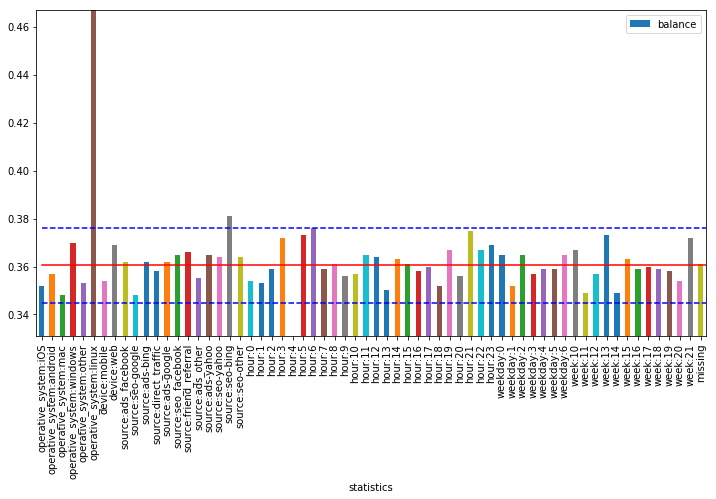

The expected (median) rate of being assigned to the treatment class is 0.36. The highest rate of assignment (0.467) is for group operative_system:linux. The lowest rate of assignment (0.331) is for group hour:4


In [15]:
%matplotlib inline
import matplotlib
# import and process the data
Y,X_continuous,X_categorical,X_spatial, X_embed, Y_factors, X_embed_factors, balance_stats = import_clean_data(path_to_data = "test_results.csv", path_to_uData = "user_table.csv", doplot = True)

X_categorical = X_categorical.astype(np.float32)



## Predictive Modelling: PART 1
Here, we will try to answer the question: is total revenue greater if everyone had price 1 or price 2 (higher). First, we will run a neural network, using all features (including the price-treatment) to predict whether or not someone will make a purchase. The target is 0/1.

In [18]:
# use a keras model:
from sklearn.model_selection import train_test_split 
from sklearn.utils import class_weight
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.models import Model
import tensorflow as tf
tf.Session(config=tf.ConfigProto(log_device_placement=True)) 

# class weights (for the unbalanced design
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y),Y)
 
X_embed_train, X_embed_test, X_cont_train,X_cont_test, X_cate_train,X_cate_test, Y_train,Y_test = train_test_split(X_embed, X_continuous, X_categorical, Y, test_size = 0.5, random_state = 89)

# Model 2: mix of embeddings and co
dim_embed_cities = 4
batch_size = 200
# embedding data
layer_embed_input = Input(shape=(X_embed.shape[1],), dtype='int32', name='embed_input',) # embedding input
layer_embed = Embedding(input_dim=max(X_embed)[0], output_dim=dim_embed_cities, input_length=X_embed.shape[1])(layer_embed_input)
layer_embed_flat = Flatten()(layer_embed)
# continuous data
layer_cont_input = Input(shape=(X_continuous.shape[1],), dtype='float32', name='cont_input',) # continuous input
layer_contdense1 = Dense(5, activation='relu')(layer_cont_input)
layer_contdense1 = Dropout(0.3)(layer_contdense1)
# categorical data 
layer_cate_input = Input(shape=(X_categorical.shape[1],), name='cate_input',) # continuous input 
layer_catdense1 = Dense(10, activation='relu')(layer_cate_input)
layer_catdense1 = Dropout(0.3)(layer_catdense1)
merge_inputs = concatenate([layer_embed_flat, layer_contdense1, layer_catdense1],axis=1)
hidden_layer1 = Dense(10, activation='relu')(merge_inputs)
hidden_layer1 = Dropout(0.3)(hidden_layer1)
hidden_layer2 = Dense(5, activation='relu')(hidden_layer1)
main_output = Dense(1, activation='sigmoid', name='main_output')(hidden_layer2) # main output for categories
model = Model(inputs=[layer_embed_input,layer_cont_input,layer_cate_input], outputs=[main_output]) 
model.compile(loss = "binary_crossentropy", optimizer='adam',metrics = ['accuracy'])
print(model.summary())
model.fit([X_embed_train, X_cont_train,X_cate_train], Y_train, epochs = 3, batch_size=batch_size, verbose = 2, class_weight = class_weights, validation_data=([X_embed_test, X_cont_test,X_cate_test],Y_test))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embed_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
cont_input (InputLayer)         (None, 3)            0                                            
__________________________________________________________________________________________________
cate_input (InputLayer)         (None, 22)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 4)         3688        embed_input[0][0]                
__________________________________________________________________________________________________
dense_5 (D

In [19]:

# Case1: what if everyone had the low price
X_case1 = X_categorical
X_case1[:,0] = X_case1[:,0]*0 +1
X_case1[:,1] = X_case1[:,1]*0
X_case1 = X_case1.astype(np.float32)
# predicted conversions if everyone is case1 (low price)
p_case1 = model.predict([X_embed, X_continuous, X_case1])

# Case2: what if everyone had the high price?
X_case2 = X_categorical
X_case2[:,0] = X_case2[:,0]*0
X_case2[:,1] = X_case2[:,1]*0+1
X_case2 = X_case2.astype(np.float32)
# Case2: predicted conversions if everyone is case2 (high price) 
p_case2 = model.predict([X_embed, X_continuous, X_case2])

# calculate expected revenues
price1 = 39
price2 = 59
ExpRevenue_1 = (p_case1*price1).sum()
ExpRevenue_2 = (p_case2*price2).sum()
ExpRevenuePerPerson_1 = (p_case1*price1).mean()
ExpRevenuePerPerson_2 = (p_case2*price2).mean()
print("The expected revenue per visitor with price $%s is $%s/person, while the expected revenue per visitor with price $%s is $%s/person. Total revenue for either case would be $%s and $%s." % (str(price1),str(ExpRevenuePerPerson_1),str(price2),str(ExpRevenuePerPerson_2),str(ExpRevenue_1),str(ExpRevenue_2)))


The expected revenue per visitor with price $39 is $1.4638864/person, while the expected revenue per visitor with price $59 is $1.8068123/person. Total revenue for either case would be $463759.2 and $572398.1.


## Result 1
The expected revenue per visitor with price \\$39 is \\$ 0.84572273/person, while the expected revenue per visitor with price \\$59 is \\$ 1.0485306/person. Total revenue for either case would be \\$ 267924.97 and \\$ 332174.47.

## Geographic Variation
Let's cluster people's geographic variation. This means graphing and clustering the learned embedding layer.

Oops, I ran out of time!

<IPython.core.display.Javascript object>


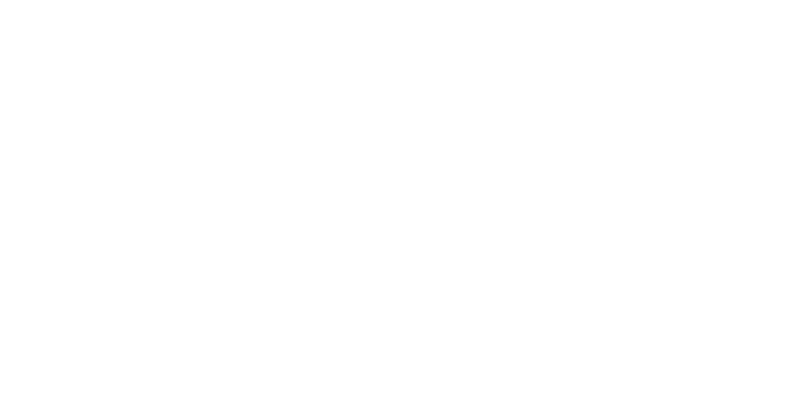

<IPython.core.display.Javascript object>


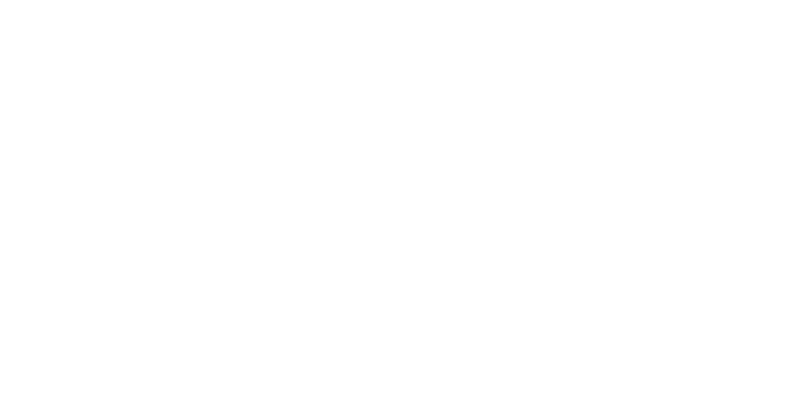

In [40]:
# extract the city weighting
city_embedding = model.layers[3].get_weights() # this is the embeddings of the 3000 words in 194 dimensions
city_embedding[0].shape

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=300)
tsne_res = tsne.fit_transform(city_embedding[0])
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4) # You want cluster the passenger records into 2: Survived or Not survived
kmeans.fit(city_embedding[0]) # fit the kmeans
grp_kmeans = kmeans.predict(city_embedding[0])

# plot the kmeans groups
from matplotlib import pyplot as plt
clmap = plt.cm.get_cmap('nipy_spectral') # color palette
vColour = clmap(grp_kmeans/max(grp_kmeans)) # assign colors to different kmeans-clusters
plt.scatter(tsne_res[:,0],tsne_res[:,1], label='City Embedding (t-SNE)', c=vColour, s=25, marker="o")
plt.title('Clustering of Cities\\n (Low-Dimensional Embedding)')
plt.ylabel('t-SNE Embedding Dimension 2')
plt.xlabel('t-SNE Embedding Dimension 1')
plt.show()


 ## Bootstrapping and Time-slicing
 ### Was there a 'significant' difference due to price at an earlier date?
 Finally, we want to see WHEN we could have stopped the A/B testing. I will look at 4 earlier time slices, and estimate the probability that revenue in the High-Price scenario is greater than the Low-price scenario. This repeated what I did above, just that there are two additional changes to the data:
 + the data must be SUBSETTED by juliandays < J (where J is 4 time slices).
 + for each time slice, I will bootstrap the data 25 times.

It is the bootstrap that allows us to estimate a probability distribution for whether or not the High-price scenario resulted in greater revenue. <b> Warning</b> the bootstrap takes a long time (about a 2-hours on my retail laptop).


In [ ]:
# strategy: we will do a 25's bootstrap to estimate a distribution of revenue at different time slices
# Estimating WHEN to stop the test:

# the 'julian_day vector' X_continuous[:,2]
# ... we will divide the time into 5 different time periods
day_thresholds = np.quantile(X_continuous[:,2], [0.2,0.4,0.6,0.8])
nBootstraps = 25
Higher_price_better = np.zeros([len(day_thresholds), nBootstraps])
for q,jday_quantile in enumerate(day_thresholds):
   ix_subset = np.where(X_continuous[:,2] <= jday_quantile)[0]
   for b in range(0,nBootstraps):
      iB = np.random.choice(ix_subset, ix_subset.shape[0])
      dim_embed_cities = 4
      batch_size = 200
      # Recompile the model
      layer_embed_input = Input(shape=(X_embed.shape[1],), dtype='int32', name='embed_input',) # embedding input
      layer_embed = Embedding(input_dim=max(X_embed)[0], output_dim=dim_embed_cities, input_length=X_embed.shape[1])(layer_embed_input)
      layer_embed_flat = Flatten()(layer_embed)
# continuous data
      layer_cont_input = Input(shape=(X_continuous.shape[1],), dtype='float32', name='cont_input',) # continuous input
      layer_contdense1 = Dense(5, activation='relu')(layer_cont_input)
      layer_contdense1 = Dropout(0.3)(layer_contdense1)
# categorical data 
      layer_cate_input = Input(shape=(X_categorical.shape[1],), name='cate_input',) # continuous input 
      layer_catdense1 = Dense(10, activation='relu')(layer_cate_input)
      layer_catdense1 = Dropout(0.3)(layer_catdense1)
      merge_inputs = concatenate([layer_embed_flat, layer_contdense1, layer_catdense1],axis=1)
      hidden_layer1 = Dense(10, activation='relu')(merge_inputs)
      hidden_layer1 = Dropout(0.3)(hidden_layer1)
      hidden_layer2 = Dense(5, activation='relu')(hidden_layer1)
      main_output = Dense(1, activation='sigmoid', name='main_output')(hidden_layer2) # main output for categories
      model = Model(inputs=[layer_embed_input,layer_cont_input,layer_cate_input], outputs=[main_output]) 
      model.compile(loss = "binary_crossentropy", optimizer='adam',metrics = ['accuracy'])
      model.fit([X_embed[iB], X_continuous[iB,:], X_categorical[iB]], Y[iB], epochs = 3, batch_size=batch_size, verbose = 2, class_weight = class_weights)
      # Case1: what if everyone had the low price
      p_case1 = model.predict([X_embed[ix_subset], X_continuous[ix_subset], X_case1[ix_subset]])
      p_case2 = model.predict([X_embed[ix_subset], X_continuous[ix_subset], X_case2[ix_subset]])
      # Estimate the total revenue for this bootstrap
      ExpRevenue_1 = (p_case1*price1).sum() # total revenue low prices
      ExpRevenue_2 = (p_case2*price2).sum() # total revenue high prices
      # is Revenue 1 higher than revenue 2?
      Higher_price_better[q,b] = 1*(ExpRevenue_2 >= ExpRevenue_1) # score: did higher prices result in higher revenue
      del model # free up some space



# the expected P(HIGHER>LOWER PRICE) is just the row means 
foo = Higher_price_better
p_higher_better = foo.mean(axis=1)
p_higher_better_sd = pow(foo.var(axis=1) ,0.5)
 
from matplotlib import pyplot as plt
plt.plot([float(i)/5.0 for i in range(0,len(p_higher_better))], p_higher_better,"b")
plt.plot([float(i)/5.0 for i in range(0,len(p_higher_better))], [0.95]*4,"r--") 
#plt.plot([float(i)/5.0 for i in range(0,len(p_higher_better))], p_higher_better+p_higher_better_sd,"r--")
#plt.plot([float(i)/5.0 for i in range(0,len(p_higher_better))], p_higher_better-p_higher_better_sd,"r--")  
plt.title("Probability Higher Prices Yields Higher Revenue \n(per earlier quarters of the experiment)")
plt.xlabel("Quarters of the Experiment (stopping earlier)")
plt.ylabel("Probability Revenue Higher \n with Higher Price")
plt.savefig('Bootstrap_estimate_Higher_Revenue.png', bbox_inches='tight')


![boostrap](https://raw.githubusercontent.com/InsightTO/18C/master/DataChallenge2/Submissions/Bootstrap_estimate_Higher_Revenue.png?token=ACAFGF2UfjiOH_4i_Mlb7xP5TzNv5m8Fks5b036BwA%3D%3D)

## Results of the bootstrap
+ if we stop the AB test in the FIRST QUARTER, there is a <b>72\% probability</b> of the revenue being higher from higher prices. Is that enough certainty? (yes!)
+ if SECOND QUARTER, there is a <b>88\% probability</b> of the revenue being higher from higher prices. Is that enough certainty: absolutely yes.
+ after THREE QUARTERS, the _probability of the revenue being higher from the experimental treatment is >90\%_. That is enough certainty to justify a decision, IMHO.

<b>Therefore, we could stop the AB test earlier, between 20% or 40% to get a farily high level of credibility.</b>